<a href="https://colab.research.google.com/github/ravitata/conv_networks/blob/main/siamese_networks/siamese_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/

https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/

https://www.pyimagesearch.com/2020/12/07/comparing-images-for-similarity-using-siamese-networks-keras-and-tensorflow/

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

a = np.array([1,2,3,4,5,6,7,8,9,0])
#print(a)
np.where(a%2==0)[0]

array([1, 3, 5, 7, 9])

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)


11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [3]:
def make_pairs(images, labels):
  pair_images = []
  pair_labels = []

  num_classes = len(np.unique(labels))
  
  idx = [np.where(labels == i)[0] for i in range(0, num_classes)]
  #print(idx)
  
  for i in range(0, len(labels)):
    curr_img = images[i]
    curr_label = labels[i]

    pos_idx = np.random.choice(idx[curr_label])
    pos_img = images[pos_idx]
    
    pair_images.append([curr_img, pos_img])
    pair_labels.append(1)

    neg_idx = np.random.choice(np.where(labels != curr_label)[0])
    neg_img = images[neg_idx]

    pair_images.append([curr_img, neg_img])
    pair_labels.append(0)
  
  return np.array(pair_images), np.array(pair_labels)


In [4]:
train_pair, train_labels = make_pairs(x_train, y_train)
test_pair, test_labels = make_pairs(x_test, y_test)
print(train_pair.shape)
print(train_labels.shape)

(120000, 2, 28, 28)
(120000,)


In [38]:
def show_pair_images(img_idx, pair_images, pair_labels):
  fig = plt.figure()
  #fig.title('Label = '+pair_labels[img_idx])
  plt.subplot(1,2,1)
  plt.imshow(pair_images[img_idx,0,:,:])
  plt.subplot(1,2,2)
  plt.imshow(pair_images[img_idx,1,:,:])
  y = pair_labels[img_idx].astype(str)
  y_desc = 'Positive'
  if y == '0':
    y_desc = 'Negative'
      
  plt.title('Label = '+y+' - '+y_desc)

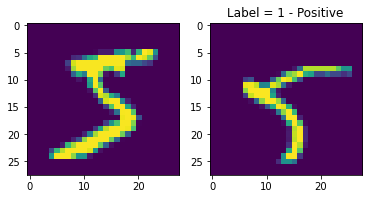

In [40]:
show_pair_images(0, train_pair, train_labels)

In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K

In [8]:
def build_seimese_model(inputShape, embeddingDim = 48):
  inputs = tf.keras.layers.Input(shape=inputShape)

  #1st layer
  x = tf.keras.layers.Conv2D(64,(2,2), padding='same', activation='relu',)(inputs)
  x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
  x= tf.keras.layers.Dropout(0.3)(x)

  #2nd layer
  x = tf.keras.layers.Conv2D(64,(2,2), padding='same', activation='relu')(x)
  x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
  x= tf.keras.layers.Dropout(0.3)(x)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  outputs = tf.keras.layers.Dense(embeddingDim)(x)

  model = tf.keras.models.Model(inputs, outputs)

  return model
  

In [9]:
def euclidean_distance(vector):
  (featuresA, fealturesB) = vector

  sumofSquare = K.sum(K.square(featuresA - fealturesB), axis = 1, keepdims=True)

  return K.sqrt(K.maximum(sumofSquare, K.epsilon()))

In [10]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [11]:
#building Siamese network
imgA = tf.keras.layers.Input(shape=(28,28,1))
imgB = tf.keras.layers.Input(shape=(28,28,1))

featureExtractor = build_seimese_model((28,28,1))

featuresA = featureExtractor(imgA)
featuresB = featureExtractor(imgB)

featureExtractor.compile()
featureExtractor.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                         

In [12]:
distance = tf.keras.layers.Lambda(euclidean_distance)([featuresA, featuresB])
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(distance)
model = tf.keras.models.Model(inputs=([imgA, imgB]), outputs = outputs)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 48)           19888       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [14]:
history = model.fit(x=[train_pair[:,0], train_pair[:,1]]
          , y=train_labels[:]
          , validation_data=[[test_pair[:,0], test_pair[:,1]]
                             , test_labels[:]]
          , batch_size=32
          , epochs = 5)

Epoch 1/5
3750/3750 [==============================] - 19s 5ms/step - loss: 0.6933 - accuracy: 0.5017 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
3750/3750 [==============================] - 20s 5ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
3750/3750 [==============================] - 18s 5ms/step - loss: 0.6602 - accuracy: 0.5773 - val_loss: 0.6051 - val_accuracy: 0.6880
Epoch 5/5
3750/3750 [==============================] - 20s 5ms/step - loss: 0.5945 - accuracy: 0.6810 - val_loss: 0.5230 - val_accuracy: 0.7622


In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


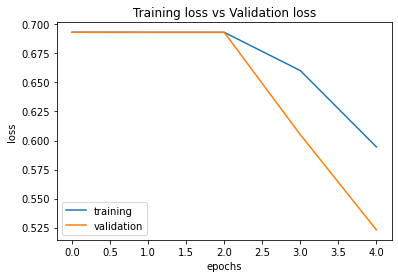

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss vs Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['training', 'validation'],loc='lower left')
plt.show()

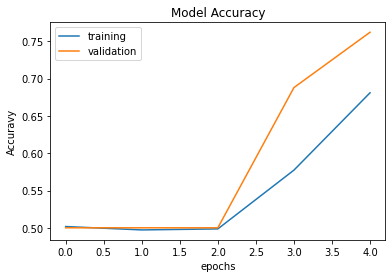

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuravy')
plt.legend(['training', 'validation'],loc='upper left')
plt.show()

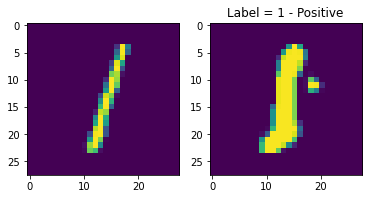

In [73]:
#prediction

idx = 4
imgA = test_pair[idx, 0, :, :]
imgB = test_pair[idx, 1, :, :]
y = test_labels[idx].astype(str)

plt.subplot(1,2,1)
plt.imshow(imgA)
plt.subplot(1,2,2)
plt.imshow(imgB)


y_desc = 'Positive'
if y == '0':
   y_desc = 'Negative'
      
plt.title('Label = '+y+' - '+y_desc)
plt.show()


In [74]:
#add channel dim
print(imgA.shape)
print(imgB.shape)
imgA1 = tf.expand_dims(imgA, axis = -1)
imgB1 = tf.expand_dims(imgB, axis = -1)

#add batch dim
imgA2 = tf.expand_dims(imgA1, axis = 0)
imgB2 = tf.expand_dims(imgB1, axis = 0)

print(imgA2.shape)
print(imgB2.shape)

preds = model.predict([imgA2, imgB2])
print('Probability/similarity score = ', preds[0][0])



(28, 28)
(28, 28)
(1, 28, 28, 1)
(1, 28, 28, 1)
Probability/similarity score =  0.7730725
